In [18]:
import implementations
import pandas as pd
import numpy as np
import helpers
import preprocessing


In [19]:
datapath_train = "./dataset/"
x_train, x_test, y_train, train_ids, test_ids = helpers.load_csv_data(datapath_train)
data_path_names = "./dataset/x_train.csv"
feature_names = np.genfromtxt(data_path_names, max_rows=2, delimiter=",", names=True).dtype.names
feature_names = feature_names[1:]  
columns = np.asarray(feature_names[0:])

In [20]:
%reload_ext autoreload
%autoreload 2
import preprocessing
import importlib
importlib.reload(preprocessing)
from preprocessing import *
from metrics import *

In [47]:
x_train_preprocess, x_test_preprocess, y_train = preprocessing.dataPreprocess(x_train, x_test, y_train, columns, feature_names)
x_train_preprocess.shape,x_test_preprocess.shape #curent size : 632

/Users/antoineschutz/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/antoineschutz/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


((328135, 632), (109379, 632))

In [48]:
import cross_validation as cv
import metrics
import matplotlib.pyplot as plt

N = x_train_preprocess.shape[0]
subset_size = N //5

# print(x_new_del_train.shape)
# print(y_train.shape)

# Generate random indices to select data points for the subset
indices = np.random.choice(len(x_train), subset_size, replace=False)

# Create the random subset from x_train and y_train
x_cv = x_train_preprocess[indices]
y_cv = y_train[indices]

initial_w = -np.ones(x_cv.shape[1])

x_cv.shape,y_cv.shape


((65627, 632), (65627,))

In [37]:
def plot_confusion_matrix(actual_y, pred_y, title):
    tp, tn, fp, fn = metrics.calculate_parameters(pred_y, actual_y)
    # Create a confusion matrix plot
    confusion_matrix = [[tn, fp], [fn, tp]]

    plt.imshow(confusion_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.colorbar()

    plt.xticks([0, 1], ["Predicted (-1)", "Predicted (1)"])
    plt.yticks([0, 1], ["Real value is (-1)", "Real value is (1)"])

    for i in range(2):
        for j in range(2):
            cell_value = confusion_matrix[i][j]
            text_color = 'white' if cell_value > 50000 else 'black'  # Adjust the threshold as needed
            plt.text(j, i, str(confusion_matrix[i][j]), ha='center', va='center', color=text_color, fontsize=16)

    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(title)

    plt.show()

In [ ]:
def plot_best_threshold(y_pred, y_cv): 
    # Create an array of threshold values to test
    thresholds = [-10, -5, -3, -1, -0.5, 0, 0.5, 1, 3, 5, 10]

    # Initialize an empty list to store F1 scores
    f1_scores = []

    for threshold in thresholds:
        pred_discrete = np.where(y_pred >= threshold, 1, -1)
        tp, tn, fp, fn = metrics.calculate_parameters(pred_discrete, y_cv)
        
        # Calculate F1 score and store it
        f1 = metrics.f1_score(tp, fp, fn)
        f1_scores.append(f1)

    # Create a line plot to visualize F1 scores vs. threshold values
    plt.plot(thresholds, f1_scores, marker='o')
    plt.xlabel('Threshold')
    plt.ylabel('F1 Score')
    plt.title('F1 Score vs. Threshold')
    plt.grid(True)
    plt.show()

In [38]:
# Mean Squared Error GD
best_max_iters, best_gamma  = cv.cross_validation_linear_regression(y_cv, x_cv, sgd=False, k=5, threshold=0, max_iters_list=[1000], gamma_list=[0.01])

w, _ = implementations.mean_squared_error_gd(y_cv, x_cv, initial_w, best_max_iters, best_gamma)
pred = x_cv.dot(w)
pred_discrete = np.where(pred >= 0, 1, -1)

#plot_best_threshold(pred, y_cv)

print(pred)

#plot_confusion_matrix(y_cv, pred_discrete, "GD linear regression")

Best gamma value is 0.01
Best max_iters value is 1000
________________________
Average F1 score: 12.98 %
Average accuracy: 71.12 %
________________________


In [ ]:
# Mean Squared Error SGD
best_max_iters, best_gamma  = cv.cross_validation_linear_regression(y_cv, x_cv, sgd=True, k=5, threshold=0, max_iters_list=[1000], gamma_list=[0.01])

w, _ = implementations.mean_squared_error_sgd(y_cv, x_cv, initial_w, best_max_iters, best_gamma)
pred = x_cv.dot(w)
pred_discrete = np.where(pred >= 0, 1, -1)    

plot_confusion_matrix(y_cv, pred_discrete, "SGD linear regression")

________________________
The average F1 score: 15.59 %
The average accuracy: 91.71 %
________________________


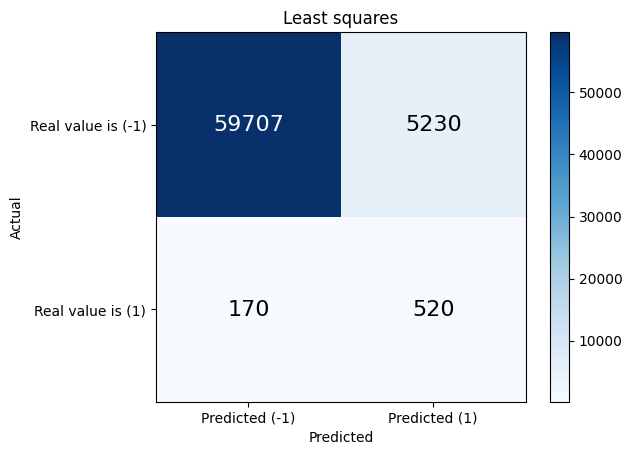

In [50]:
# Least squares
# With k=30 and subset_size=200 000, best F1 score = 11.75%
cv.cross_validation_least_squares(y_cv, x_cv)

w, _ = implementations.least_squares(y_cv, x_cv)
pred = x_cv.dot(w)
pred_discrete = np.where(pred >= 0, 1, -1)    

plot_confusion_matrix(y_cv, pred_discrete, "Least squares")

Best lambda value is 1e-16
________________________
Average F1 score: 15.59 %
Average accuracy: 91.71 %
________________________


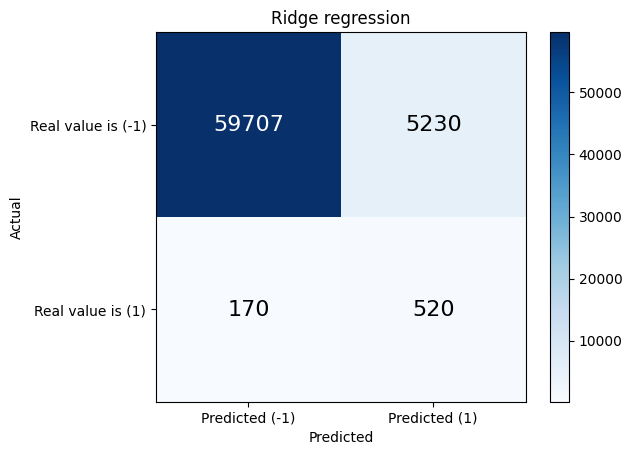

In [51]:
# Ridge regression
# Best lambda = 0.0011
min_lambda = 0.000000001
max_lambda = 1.0
step_size = 0.01

#lambda_values = [min_lambda + step_size * i for i in range(int((max_lambda - min_lambda) / step_size) + 1)]

best_lambda = cv.cross_validation_ridge_regression(y_cv, x_cv, lambda_values=[1e-16,1e-15,1e-14,1e-13,1e-12,1e-11,1e-10])

w, _ = implementations.ridge_regression(y_cv, x_cv, 1e-16)
pred = x_cv.dot(w)
pred_discrete = np.where(pred >= 0, 1, -1)

plot_confusion_matrix(y_cv, pred_discrete, "Ridge regression")



In [52]:
# Logistic regression
best_max_iters, best_gamma = cv.cross_validation_logistic(y_cv, x_cv)

w, _ = implementations.logistic_regression(y_cv, x_cv, initial_w, best_max_iters, best_gamma)
pred = x_cv.dot(w)
pred_discrete = np.where(pred >= 0.5, 1, -1)

plot_confusion_matrix(y_cv, pred_discrete, "Logistic regression")


Current iteration=0, loss=-28.500970411281667


KeyboardInterrupt: 

In [35]:
w, _ = implementations.ridge_regression(y_train, x_train_preprocess, 1e-16)
pred = x_test_preprocess.dot(w)
pred_discrete = np.where(pred >= 0, 1, -1)

helpers.create_csv_submission(test_ids, pred_discrete, "Submission_ridge_regression_new_preProcess.csv")


